# Data pipeline example

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import json
import tensorflow as tf

tf.enable_eager_execution()

In [3]:
from phaunos_ml.utils.dataset_utils import read_dataset_file

In [37]:
ROOT_PATH = './data/birdid_dataset/'
BIRDS_DIR = 'birds'
NOISE_DIR = 'noise'
DATASET_BIRDS_FILE = os.path.join(ROOT_PATH, BIRDS_DIR, 'dataset.csv')
LABEL_FILE = os.path.join(ROOT_PATH, BIRDS_DIR, 'labels.csv')
AUDIO_DIR = 'audio'
ANNOTATION_DIR = 'annotations'
FEATURE_DIR = 'features'
ACTIVITY_DETECTION_CFG = os.path.join(ROOT_PATH, 'activity_detection.json')

## Configure activity detector

Because bird vocalisations are very sparse (e.g. only a few seconds of vocalisations in a 1 min audio file), and we do not want our model to be trained with audio chunks containing no activity, we must detect audio chunks containing activity.

Audio chunks containing audio activity will be written to a directory named <b><i>positive</i></b> and audio chunks containing no activity will be written to <b><i>negative</i></b>

In [20]:
from nsb_aad.frame_based_detectors.mario_detector import MarioDetector

In [25]:
activity_detection_cfg = json.load(open(ACTIVITY_DETECTION_CFG, 'r'))
activity_detector = MarioDetector(activity_detection_cfg)
activity_detection_cfg

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

## Configure feature extractor

We want to use mel-spectrogram as our model input, but because some audio augmentation methods (e.g. Mixup) are applied to the raw audio, we write raw audio chunks of 1s, with no overlap, to the TFRecords, and we will a compute the mel-spectrogram at run time

In [26]:
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor

In [36]:
sr = 22050
segment_duration = 1 # in seconds
segment_hop_duration = 1 # in seconds
feature_extractor = AudioSegmentExtractor(
    sr=sr,
    example_duration=segment_duration,
    example_hop_duration=segment_hop_duration)

## Write bird TFRecords

In [29]:
from phaunos_ml.utils.dataset_utils import dataset2tfrecords

In [34]:
dataset2tfrecords(
        os.path.join(ROOT_PATH, BIRDS_DIR),
        DATASET_BIRDS_FILE,
        os.path.join(ROOT_PATH, BIRDS_DIR, FEATURE_DIR),
        feature_extractor,
        activity_detector=activity_detector,
        min_activity_dur=0.05,
        audio_dirname='audio',
        annotation_dirname='annotations',
        with_labels=True
)

100%|██████████| 2/2 [00:01<00:00,  1.03s/it]


## Write noise TFRecords

In [15]:
dataset_birds = read_dataset_file(DATASET_BIRDS_PATH)
dataset_birds

(['XC370891.M.wav', 'XC78163.L.wav'], [{268}, {324}])

## Get noise dataset

In [ ]:
Read dataset file (line in the file contains the audio filename and the associated label(s) in the following format:
<br>`<filename>,<label1>(#<label2>...#<labelN>)`
<br>`<filename>,<label1>(#<label2>...#<labelN>)`
<br>...

In [32]:

import json
import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from phaunos_ml.utils.dataset_utils import create_subset, dataset_stat_per_file, read_dataset_file
from phaunos_ml.utils.dataug_utils import tfrecords2dataset_aug, tfrecords2tfdataset, mixup
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
#from phaunos_ml.utils.dataset_utils import dataset2tfrecords
from phaunos_ml.utils import tf_utils
from phaunos_ml.utils.tf_utils import serialized2data
from nsb_aad.frame_based_detectors.mario_detector import MarioDetector

tf.enable_eager_execution()



/home/jul/.miniconda3/envs/phaunos_ml/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
ROOT_PATH = '/home/jul/data/xenocanto/'
LABEL_FILENAME = '/home/jul/data/xenocanto/labels.csv'
SUBSET_PATH = os.path.join(ROOT_PATH, 'custom_subsets')
AUDIO_DIRNAME = 'audio/wav_22050hz_MLR'
ANNOTATION_DIRNAME = 'annotations'

In [5]:
# create Xeno-Canto data subset with 5 randomly picked classes
class_list = sorted([line.strip() for line in open(LABEL_FILENAME, 'r')])
subset_label_set = set(np.random.choice(range(len(class_list)), 2, replace=False))
print(f'Classes: {subset_label_set}')
subset_filename = create_subset(
    ROOT_PATH,
    ['.'],
    SUBSET_PATH,
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME,
    label_set=subset_label_set)
print(subset_filename)

Classes: {60, 141}
/home/jul/data/xenocanto/custom_subsets/subset_1570008079/subset_1570008079.csv


In [6]:
# Show dataset stats
# Note: The total number of instances might be higher than the number of audio files because a file might have multiple labels
d_num, d_dur = dataset_stat_per_file(ROOT_PATH, subset_filename)
print("Class index, number of files, total duration (in s)") 
for k, v in sorted(d_num.items()): 
    print(f' {k} ({class_list[k]}), {v}, {d_dur[k]:<.3f}')

19it [00:00, 1085.04it/s]

Class index, number of files, total duration (in s)
 60 (ardenna_pacifica), 10, 468.887
 141 (coracias_garrulus), 9, 298.369


In [7]:
# configure activity detector
config_file_mario = '/home/jul/dev/nature_sound_box/nsb_aad/configs/mario.json'
config_mario = json.load(open(config_file_mario, 'r'))
mario_detector = MarioDetector(config_mario)
config_mario

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

In [8]:
# configure audio segment extractor
sr = 22050
segment_dur = 1
segment_hop_dur = 1
audio_ex = AudioSegmentExtractor(sr=sr, example_duration=segment_dur, example_hop_duration=segment_hop_dur)

In [9]:
# generate feature
from phaunos_ml.utils.dataset_utils import dataset2tfrecords
tfrecord_path = os.path.join(os.path.dirname(subset_filename), 'features')
dataset2tfrecords(ROOT_PATH,                  
                  subset_filename,
                  tfrecord_path,
                  feature_extractor=audio_ex,
                  activity_detector=mario_detector,
                  min_activity_dur=0.04,                  
                  audio_dirname=AUDIO_DIRNAME,
                  annotation_dirname=ANNOTATION_DIRNAME
                 )

100%|██████████| 20/20 [00:05<00:00,  2.93it/s]


In [10]:
# check some examples
example_filenames = random.sample(os.listdir(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME)), 2)
example1 = tf_utils.tfrecord2example(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME, example_filenames[0]), audio_ex)
example2 = tf_utils.tfrecord2example(os.path.join(tfrecord_path, 'positive', AUDIO_DIRNAME, example_filenames[1]), audio_ex)

W1002 11:23:42.366763 140554214725440 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


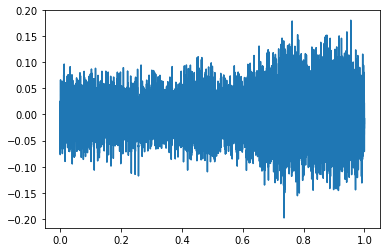

In [11]:
audio_ex.plot(example1[0]['data'][0])

In [39]:
from phaunos_ml.utils.dataset_utils import create_subset

In [13]:
# get training and augmentation files lists
train_files, train_labels = read_dataset_file(
    subset_filename,
    prepend_path=os.path.join(tfrecord_path, 'positive'),
    replace_ext='.tf')
aug_files, aug_labels = read_dataset_file(
    subset_filename,
    prepend_path=os.path.join(tfrecord_path, 'negative'),
    replace_ext='.tf')

In [15]:
print(f'{train_files[3]}, {train_labels[3]}')

/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/positive/audio/wav_22050hz_MLR/XC137486.R.tf, {141}


In [17]:
print(f'{aug_files[5]}, {aug_labels[5]}')

/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/negative/audio/wav_22050hz_MLR/XC303133.M.tf, {60}


In [18]:
class_list = sorted(list(set.union(*train_labels)))
class_list

[60, 141]

In [36]:
# map to dataset
tf_train_files = tf.convert_to_tensor(train_files, dtype=dtypes.string)

In [37]:
tf_train_files = tf.data.Dataset.from_tensor_slices(tf_train_files)

In [55]:
dataset = tf_train_files.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=8)

In [56]:
dataset

<DatasetV1Adapter shapes: (), types: tf.string>

In [57]:
dataset = dataset.map(lambda x: serialized2data(x, audio_ex.feature_shape, class_list, training=False))
dataset

<DatasetV1Adapter shapes: ((1, 1, 22050), (2,), (), (2,)), types: (tf.float32, tf.float32, tf.string, tf.float32)>

In [58]:
dataset_aug = tf.data.TFRecordDataset(aug_files)

In [59]:
dataset_aug

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [60]:
dataset_aug = dataset_aug.map(lambda x: serialized2data(x, audio_ex.feature_shape, class_list, training=True))

In [61]:
dataset = dataset.map(lambda feat, labels: (feat, labels))

TypeError: <lambda>() takes 2 positional arguments but 4 were given

In [43]:
subset = create_subset('/home/jul/data/xenocanto/', ['.'], '/home/jul/', label_set=set([4,9]), audio_dirname='audio/wav_22050hz_MLR')

In [44]:
subset

'/home/jul/subset_1571233036/subset_1571233036.csv'

In [50]:
from phaunos_ml.utils.dataset_utils import read_dataset_file, split_dataset

In [47]:
filenames, labels = read_dataset_file('/home/jul/data/xenocanto/', subset,audio_dirname='audio/wav_22050hz_MLR')

In [49]:
labels

[{9},
 {9},
 {9},
 {9},
 {9},
 {4},
 {9},
 {9},
 {9},
 {4},
 {9},
 {9},
 {9},
 {9},
 {9},
 {4},
 {4},
 {9},
 {9},
 {9}]

In [51]:
split_dataset('/home/jul/data/xenocanto/', subset,audio_dirname='audio/wav_22050hz_MLR')

/home/jul/subset_1571233036/subset_1571233036.train.csv written
/home/jul/subset_1571233036/subset_1571233036.test.csv written


In [52]:
for f, l in zip(filenames, labels):
    print(f'{f}, {l}')

audio/wav_22050hz_MLR/XC443243.L.wav, {9}
audio/wav_22050hz_MLR/XC74567.L.wav, {9}
audio/wav_22050hz_MLR/XC74568.R.wav, {9}
audio/wav_22050hz_MLR/XC443243.R.wav, {9}
audio/wav_22050hz_MLR/XC74569.L.wav, {9}
audio/wav_22050hz_MLR/XC40178.R.wav, {4}
audio/wav_22050hz_MLR/XC74572.L.wav, {9}
audio/wav_22050hz_MLR/XC74571.R.wav, {9}
audio/wav_22050hz_MLR/XC74570.L.wav, {9}
audio/wav_22050hz_MLR/XC327373.R.wav, {4}
audio/wav_22050hz_MLR/XC74571.L.wav, {9}
audio/wav_22050hz_MLR/XC443239.L.wav, {9}
audio/wav_22050hz_MLR/XC74568.L.wav, {9}
audio/wav_22050hz_MLR/XC74567.R.wav, {9}
audio/wav_22050hz_MLR/XC74572.R.wav, {9}
audio/wav_22050hz_MLR/XC40178.L.wav, {4}
audio/wav_22050hz_MLR/XC327373.L.wav, {4}
audio/wav_22050hz_MLR/XC74570.R.wav, {9}
audio/wav_22050hz_MLR/XC443239.R.wav, {9}
audio/wav_22050hz_MLR/XC74569.R.wav, {9}


In [57]:
from phaunos_ml.utils.dataset_utils import dataset2tfrecords, dataset_stat_per_file, dataset_stat_per_example

In [56]:
dataset2tfrecords('/home/jul/data/xenocanto/', subset, "/home/jul/features", feature_extractor, audio_dirname='audio/wav_22050hz_MLR')

100%|██████████| 21/21 [00:04<00:00,  5.20it/s]


In [59]:
dataset_stat_per_file('/home/jul/data/xenocanto/', subset, audio_dirname='audio/wav_22050hz_MLR')

20it [00:00, 13736.05it/s]


(defaultdict(int, {9: 16, 4: 4}),
 defaultdict(float, {9: 831.5024943310658, 4: 191.89551020408163}))

In [67]:
dataset_stat_per_example('/home/jul/data/xenocanto/',
                         subset,
                         "/home/jul/features/positive",
                         feature_extractor.feature_shape,
                         [4,9],
                         audio_dirname='audio/wav_22050hz_MLR',
                         batch_size=1
                )

(1030, array([194, 836], dtype=int32))

In [69]:
831+191

1022